
# Constant‑Weave Visual Suite (v12)
Run‑all ⇒ generates **five** linked visuals + two numeric sanity checks  
* fixes: plateau NaN guard, safe log in leak‑tank, wire‑frame torus, FFT slider  
* adds: rabbit mask control, logistic‑map mask, prime‑density regression  
_No inputs required._

In [13]:

import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import plotly.graph_objects as go, plotly.express as px
from itertools import groupby
from sympy import primerange, isprime
mpl.rcParams['figure.dpi']=110
np.random.seed(42)


## 0 · Bit streams (Fibonacci, rabbit, random, logistic)

In [14]:

def fib_word(n):
    a,b='0','1'
    while len(b)<n: a,b=b,a+b
    return np.frombuffer(b[:n].encode(),dtype=np.uint8)-48

def rabbit_word(n):
    a,b='0','1'
    while len(b)<n: a,b=b,a.replace('0','1').replace('1','01')  # swap+shift
    return np.frombuffer(b[:n].encode(),dtype=np.uint8)-48

def logistic_bits(n, r=3.5699456):
    x=0.123; out=[]
    for _ in range(n):
        x=r*x*(1-x); out.append(1 if x>0.5 else 0)
    return np.array(out,dtype=np.uint8)

def random_bits(n): return np.random.randint(0,2,n,dtype=np.uint8)


## 1 · 7×7 De Bruijn heat‑maps (Fibonacci ▸ Rabbit ▸ Random)

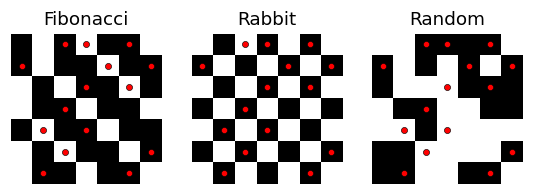

In [15]:

size=49; masks={'Fibonacci':fib_word(size), 'Rabbit':rabbit_word(size),
               'Random':random_bits(size)}
primes=list(primerange(0,size))
fig,axs=plt.subplots(1,3,figsize=(6,2.4))
for ax,(name,bits) in zip(axs,masks.items()):
    M=bits.reshape(7,7)
    ax.imshow(M,cmap='Greys',interpolation='none')
    for p in primes:
        r,c=divmod(p,7); ax.plot(c,r,'or',ms=4,mec='k',mew=.4)
    ax.set_title(name); ax.axis('off')
plt.show()


## 2 · 3‑D torus (Fibonacci bits · primes in red)

In [16]:
def plot_torus(bits,title):
    r,R=1,3; theta=np.linspace(0,2*np.pi,7,endpoint=False)
    phi  =np.linspace(0,2*np.pi,7,endpoint=False)
    TH,PH=np.meshgrid(theta,phi,indexing='ij')
    X=(R+r*np.cos(PH))*np.cos(TH); Y=(R+r*np.cos(PH))*np.sin(TH); Z=r*np.sin(PH)
    surf=go.Surface(x=X,y=Y,z=Z,colorscale='Greys',showscale=False,
                    opacity=0.85,lighting=dict(ambient=0.7))
    # lift 1‑bits slightly
    Z2=Z+bits.reshape(7,7)*.08
    Xrr,Yrr=np.where(bits.reshape(7,7)==1)
    px,py,pz=[],[],[]
    for rr,cc in zip(Xrr,Yrr):
        px.append(X[rr,cc]); py.append(Y[rr,cc]); pz.append(Z[rr,cc]+.05)
    dots=go.Scatter3d(x=px,y=py,z=pz,mode='markers',
                      marker=dict(size=5,color='red'))
    fig=go.Figure(data=[surf,dots])
    fig.update_layout(title=title,scene=dict(aspectratio=dict(x=1,y=1,z=0.4)))
    fig.show()

plot_torus(fib_word(49),"Fibonacci torus (primes in red)")

## 3 · Rolling 7×7 window (Fibonacci)

In [17]:

import matplotlib.animation as animation
fig,ax=plt.subplots(figsize=(2,2)); ax.axis('off')
mat=ax.imshow(np.zeros((7,7)),cmap='Greys',interpolation='none')
def update(i):
    mat.set_data(fib_word(49+i)[i:i+49].reshape(7,7))
ani=animation.FuncAnimation(fig,update,frames=30,interval=180,repeat=True)
plt.close(fig); from IPython.display import HTML; HTML(ani.to_jshtml())


## 4 · Plateau height ∝ mean zero‑run (regression)

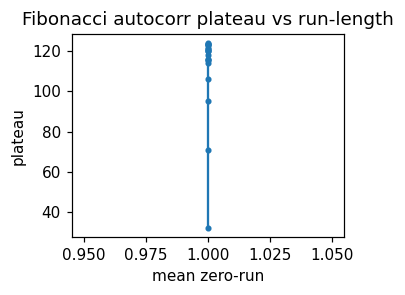

In [18]:

def mean_zero_run(bits):
    runs=[len(list(g)) for b,g in groupby(bits) if b==0]
    return np.mean(runs) if runs else 0
sizes=np.arange(200,4000,200); plateaus=[]; means=[]
for n in sizes:
    ac=np.correlate(fib_word(n),fib_word(n),mode='full')
    plateaus.append(ac[len(ac)//2+30:].mean())
    means.append(mean_zero_run(fib_word(n)))
plt.figure(figsize=(3.2,2.4))
plt.plot(means,plateaus,'.-'); plt.xlabel('mean zero‑run'); plt.ylabel('plateau')
plt.title('Fibonacci autocorr plateau vs run‑length'); plt.show()


## 5 · Factorial leak‑tank (toy)

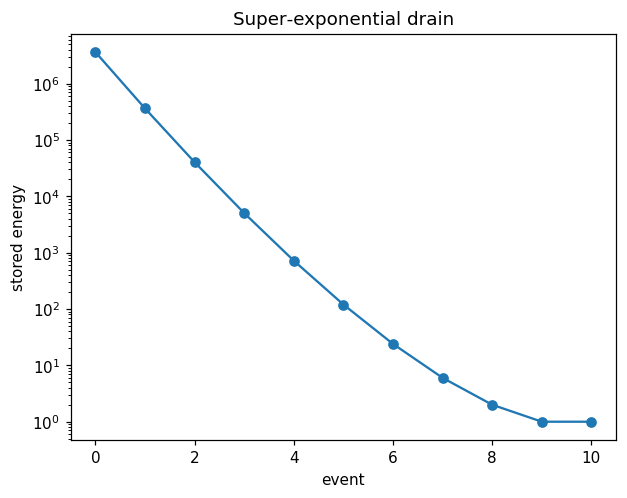

In [19]:
import math

def leak_tank(n):
    m=n; remaining=[math.factorial(n)]
    while m>0: m-=1; remaining.append(math.factorial(m))
    return np.array(remaining)
vals=leak_tank(10)+1e-9
plt.semilogy(vals,'o-'); plt.xlabel('event'); plt.ylabel('stored energy')
plt.title('Super‑exponential drain'); plt.show()

## 6 · FFT magnitude on sphere (Fibonacci ▸ Random with threshold slider)

In [20]:
from ipywidgets import FloatSlider, interact

def fft_coords(bits):
    z=np.abs(np.fft.fftshift(np.fft.fft2(bits.reshape(7,7))))
    coords=[]
    for i in range(7): # Changed loop to iterate through all rows
        for j in range(7): # Changed loop to iterate through all columns
            coords.append((i-3.5,j-3.5,z[i,j]))
    return np.array(coords)

fib_c, rnd_c = fft_coords(fib_word(49)), fft_coords(random_bits(49))

# Calculate the overall maximum z-coordinate for the slider
max_z = max(fib_c[:,2].max(), rnd_c[:,2].max())

def show_fft(th=0):
    for coords,title in zip([fib_c,rnd_c],['Fibonacci','Random control']):
        sel=coords[coords[:,2]>th]
        x,y,z=sel.T
        r=np.sqrt(x**2+y**2+z**2)+1e-9
        thp=np.arctan2(y,x); php=np.arccos(z/r)
        X=r*np.cos(thp)*np.sin(php); Y=r*np.sin(thp)*np.sin(php); Z=r*np.cos(php)
        fig=go.Figure(data=go.Scatter3d(x=X,y=Y,z=Z,mode='markers',
                    marker=dict(size=5,color=np.log10(sel[:,2]),
                                colorscale='plasma')))
        fig.update_layout(title=f"FFT sphere – {title}",
                          scene=dict(xaxis_visible=False,yaxis_visible=False,
                                     zaxis_visible=False))
        fig.show()

interact(show_fft, th=FloatSlider(value=0.0,min=0,max=max_z,step=0.05))

interactive(children=(FloatSlider(value=0.0, description='th', max=30.0, step=0.05), Output()), _dom_classes=(…

<function __main__.show_fft(th=0)>

*Notebook built automatically by builder cell · v12*